In [1]:
# import the required libraries
import numpy as np
import time
import random
import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
from sketch_rnn_class import *
from model_class import *
from utils_class import *
from rnn import *
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt
# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [2]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)

INFO:tensorflow:TensorFlow Version: 1.4.0


In [3]:
#HELPER FUNCTIONS
#function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

In [4]:
#load pathways
data_dir = 'datasets/'
models_root_dir = '' #same directory we're in now
model_dir = 'checkpoint_path/classifier'

In [5]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir)

INFO:tensorflow:Loaded 70000/2500/2500 from ear.npz
INFO:tensorflow:Loaded 70000/2500/2500 from eye.npz
INFO:tensorflow:Loaded 70000/2500/2500 from mouth.npz
INFO:tensorflow:Loaded 70000/2500/2500 from nose.npz
INFO:tensorflow:Dataset combined: 300000 (280000/10000/10000), avg len 37
INFO:tensorflow:model_params.max_seq_len 125.
total images <= max_seq_len is 280000
total images <= max_seq_len is 10000
total images <= max_seq_len is 10000
INFO:tensorflow:normalizing_scale_factor 45.8033.


In [6]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Model using gpu.


In [7]:
#run session
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [8]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model checkpoint_path/classifier/vector-50000.
INFO:tensorflow:Restoring parameters from checkpoint_path/classifier/vector-50000


We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

In [9]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes,max_len=125).tolist()
  print(np.shape(strokes))
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [10]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

In [11]:
def preprocess_single(stroke):
    scale_factor=0.15 #see model params
    stroke[:, 0:2] /= scale_factor
    return stroke

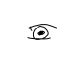

(75, 3)


In [12]:
# DRAW A STROKE
stroke = test_set.random_sample()
draw_strokes(stroke)
print(np.shape(stroke))
#print stroke

Let's try to encode the sample stroke into latent vector $z$

(21, 3)


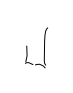

3


In [13]:
#SAMPLE AND PREDICT
stroke = test_set.random_sample()
#print model_params.scale_factor
print(np.shape(stroke))
#print stroke
draw_strokes(stroke)
#z = encode(stroke)
prediction = predict_model(sess, eval_model, stroke, 125)
print(prediction)

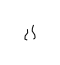

3


In [14]:
#READ IN SAMPLE AND PREDICT
data = np.load("datasets/nose.npz")
test_data = data['test']
stroke = np.random.choice(test_data)
stroke = np.array(stroke, dtype=np.float32)
#normalize stroke by dividing by normalizing scale factor
scale_factor = 45.8033
stroke[:, 0:2] /= scale_factor
draw_strokes(stroke)
prediction = predict_model(sess, eval_model, stroke, 125)
print(prediction)

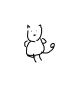

label: 1 eye


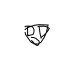

label: 3 nose


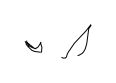

label: 3 nose


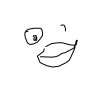

label: 1 eye


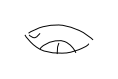

label: 1 eye


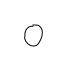

label: 3 nose


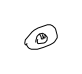

label: 1 eye


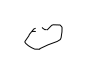

label: 3 nose


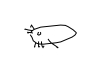

label: 1 eye


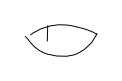

label: 1 eye


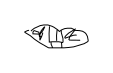

label: 1 eye


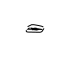

label: 1 eye


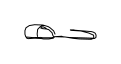

label: 1 eye


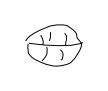

label: 1 eye


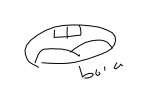

label: 1 eye


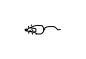

label: 1 eye


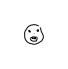

label: 3 nose


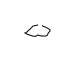

label: 3 nose


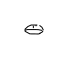

label: 1 eye


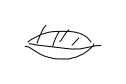

label: 1 eye


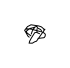

label: 3 nose


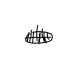

label: 1 eye


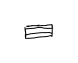

label: 1 eye


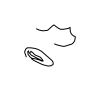

label: 1 eye


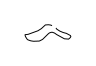

label: 3 nose


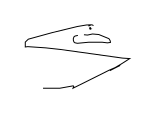

label: 1 eye


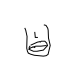

label: 3 nose


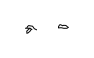

label: 1 eye


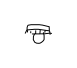

label: 1 eye


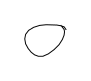

label: 3 nose


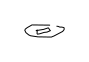

label: 1 eye


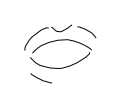

label: 1 eye


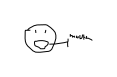

label: 1 eye


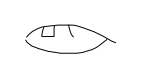

label: 1 eye
[0, 24, 2466, 10, 0]


In [15]:
#TALLY INCORRECT PREDICTIONS
data = np.load("datasets/mouth.npz")
test_data = data['test']
labels = ['ear','eye','mouth','nose']
counts = [0,0,0,0,0]
scale_factor = 45.8033
for i in range(2500):
    stroke = test_data[i]
    stroke = np.array(stroke, dtype=np.float32)
    stroke[:, 0:2] /= scale_factor
    prediction = predict_model(sess,eval_model,stroke,125)
    counts[prediction] += 1
    label = labels[prediction]
    if not(label == "mouth"):
        draw_strokes(stroke)
        print("label: " + str(prediction) + " " + label)
print counts

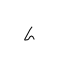

In [16]:
#READ IN SAMPLE AND PREDICT
data = np.load("datasets/nose.npz")
test_data = data['test']
stroke = np.random.choice(test_data)
stroke = np.array(stroke, dtype=np.float32)
#normalize stroke by dividing by normalizing scale factor
scale_factor = 45.8033
stroke[:, 0:2] /= scale_factor
draw_strokes(stroke)
p = pred(sess, eval_model, stroke, 125)

In [17]:
print(np.shape(p))
print(p)
p = np.array(p)
print(p)
print(p[0])
print(p[:,0])
p_class = np.argmax(p, axis=1)
print(p_class)

(1, 16)
[[  0.02236101  -5.3921275   -2.5171056   13.319989   -14.001239   -13.435577   -13.479355   -14.262276   -13.737324   -13.62582    -13.854609   -14.1306305  -14.051396   -13.513998   -14.151168
  -13.65094   ]]
[[  0.02236101  -5.3921275   -2.5171056   13.319989   -14.001239   -13.435577   -13.479355   -14.262276   -13.737324   -13.62582    -13.854609   -14.1306305  -14.051396   -13.513998   -14.151168
  -13.65094   ]]
[  0.02236101  -5.3921275   -2.5171056   13.319989   -14.001239   -13.435577   -13.479355   -14.262276   -13.737324   -13.62582    -13.854609   -14.1306305  -14.051396   -13.513998   -14.151168
 -13.65094   ]
[0.02236101]
[3]


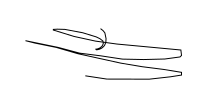

label: 0 ear
[[  2.7302725   1.3503169  -2.3439028   2.7133062 -17.466616  -17.051388  -17.274649  -17.47196   -17.609753  -17.669832  -17.662638  -17.334337  -17.728302  -17.63383   -17.497047  -17.381937 ]]


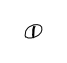

label: 1 eye
[[  1.4103171    5.3051333   -2.7751682    0.56169105 -14.654694   -14.763281   -14.490472   -14.668855   -15.037094   -14.4983425  -14.771384   -15.03155    -14.550733   -14.444932   -14.923561
  -14.800264  ]]


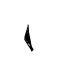

label: 0 ear
[[  2.7674742    0.7169066   -0.87424725   1.547372   -16.082335   -15.757876   -15.78446    -16.194653   -16.183046   -16.465523   -16.330765   -16.354084   -16.084785   -16.257662   -16.124691
  -16.12      ]]


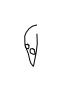

label: 0 ear
[[  3.8676639  -2.1807427  -1.1587385   3.428367  -17.130476  -16.77463   -17.156145  -17.454262  -17.14156   -17.53652   -17.446638  -17.30308   -17.472359  -17.451872  -17.859198  -17.467052 ]]


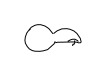

label: 1 eye
[[  0.09211186   3.6732826    0.11014916  -0.60754025 -14.34952    -13.988314   -14.17002    -14.050931   -14.373577   -13.922167   -13.923069   -14.180628   -14.3863325  -13.890048   -13.797736
  -14.361312  ]]


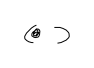

label: 1 eye
[[  2.1721516   3.0582037  -3.2456691   2.438322  -15.444357  -15.074659  -15.192265  -14.82868   -15.511974  -15.183347  -15.224908  -15.345844  -15.014499  -14.732945  -15.041962  -15.211631 ]]


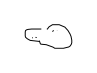

label: 0 ear
[[  2.700734     0.6583334    0.43656963   1.5919778  -15.757592   -15.928481   -15.96946    -15.634162   -16.10476    -15.702356   -15.6141     -15.995826   -15.514585   -15.546158   -16.15373
  -15.9032    ]]


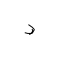

label: 0 ear
[[  5.7978253  -3.9013853  -1.9528333   3.8844628 -14.785208  -14.71778   -15.17527   -14.9126215 -15.151131  -14.93835   -14.572258  -15.150435  -14.92065   -14.510841  -15.04742   -14.699564 ]]


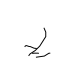

label: 0 ear
[[  3.3880591  -5.6415076   3.2476332   3.3122988 -15.938023  -15.322354  -15.909548  -16.467587  -16.148045  -16.341654  -16.35218   -16.473276  -16.083761  -16.263178  -16.440903  -16.049166 ]]


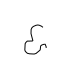

label: 0 ear
[[  5.903969   -0.9414183  -3.1059694   4.255229  -16.229496  -15.42882   -15.613202  -15.166106  -16.117353  -15.468389  -15.732663  -15.800983  -16.274185  -15.985299  -16.377626  -15.743628 ]]


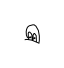

label: 0 ear
[[  3.393886    1.5122688  -2.543704    2.3269804 -14.901818  -14.856798  -14.673994  -14.703557  -14.890043  -14.780975  -14.694538  -14.972643  -14.82005   -14.483703  -14.928942  -14.915502 ]]


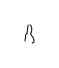

label: 0 ear
[[  7.190303   -4.367789   -1.5166242   3.924633  -15.162062  -14.372706  -14.8180275 -14.945146  -15.093694  -14.730291  -14.072345  -14.550503  -14.977002  -14.723415  -14.342538  -15.247674 ]]


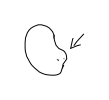

label: 0 ear
[[  3.054298    -0.69972014   2.457249     0.5958178  -12.057471   -11.578819   -11.285708   -11.145691   -11.475176   -11.24476    -11.047351   -12.235283   -11.804966   -11.274836   -11.675721
  -11.331733  ]]


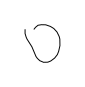

label: 0 ear
[[  4.4535956  -1.5709723   0.6251356   1.8910232 -18.25639   -17.783373  -17.162262  -17.634628  -17.73079   -17.709557  -17.62611   -17.911018  -17.39665   -17.413338  -17.568874  -17.805979 ]]


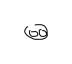

label: 1 eye
[[  0.20290026   5.051497    -0.27771297  -0.31655425 -17.431828   -17.265291   -17.023949   -17.056353   -17.053072   -17.227139   -17.200624   -17.267395   -17.168093   -17.127632   -17.178272
  -17.303396  ]]


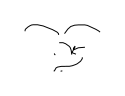

label: 0 ear
[[  2.3350744    0.42166266   0.19528253   1.7081606  -15.700062   -15.947421   -15.637647   -15.766535   -15.826172   -15.778406   -15.485865   -15.816255   -15.985101   -15.675772   -15.592226
  -15.823523  ]]


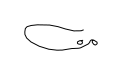

label: 1 eye
[[ -0.69689894   3.937471     1.5824193   -0.36021793 -15.030947   -15.457937   -14.993402   -15.057645   -15.542137   -14.7086735  -15.524525   -15.429276   -14.94746    -14.959993   -14.988838
  -15.847157  ]]


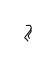

label: 0 ear
[[  7.2632966  -6.6279025  -2.7176442   5.5921683 -14.879971  -14.503221  -14.84553   -14.720487  -15.055767  -14.7277355 -14.287611  -14.909712  -14.665065  -14.299324  -15.037623  -14.606899 ]]


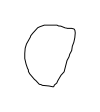

label: 0 ear
[[  6.9816623  -1.8288978  -3.1548805   4.08304   -15.783251  -15.743037  -15.802496  -15.216986  -15.9791155 -15.776905  -15.632159  -16.101665  -16.106583  -15.9138155 -16.513212  -16.227531 ]]


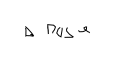

label: 0 ear
[[  2.5013719    0.25631437   0.3183055    1.3546109  -14.771779   -14.828494   -14.242797   -15.041101   -15.192319   -14.453418   -14.257795   -14.71223    -14.604831   -14.4575205  -14.729682
  -14.801813  ]]


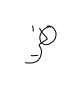

label: 0 ear
[[  6.2359977  -4.0526457  -1.0197052   4.4716988 -17.928186  -17.99398   -17.802086  -18.047771  -17.767807  -17.956165  -17.673462  -18.131546  -17.673334  -18.068878  -17.93233   -17.845367 ]]


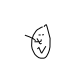

label: 0 ear
[[  4.3160434  -1.6552159   0.5411254   1.8154173 -16.716885  -16.46712   -16.511791  -16.37594   -16.6848    -16.724554  -16.415781  -16.686714  -17.157043  -16.209717  -16.421494  -16.723017 ]]


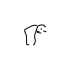

label: 0 ear
[[  3.6861641   -1.5481188   -0.20061998   2.4596744  -13.941258   -13.975511   -13.826952   -13.900856   -14.008897   -14.053221   -13.812552   -13.782525   -13.980909   -13.771353   -14.152082
  -13.998577  ]]


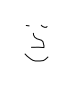

label: 2 mouth
[[  0.69236624  -3.6755443    4.1701293    2.0714688  -15.763955   -15.907061   -15.409884   -15.122298   -15.702104   -15.207421   -15.052053   -15.523372   -15.707119   -15.101265   -15.657179
  -15.264633  ]]


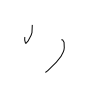

label: 0 ear
[[  6.385206   -5.679649   -1.2183353   5.325937  -14.600167  -14.392033  -14.932702  -14.82103   -14.891614  -14.642877  -14.363837  -14.656667  -14.830025  -14.783648  -14.838675  -15.271802 ]]


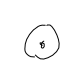

label: 0 ear
[[  6.127098     0.32796118  -1.3763831    0.6160644  -16.631435   -16.965874   -16.52665    -16.157469   -16.763227   -16.572422   -16.735119   -16.624264   -16.781185   -16.458483   -16.17501
  -16.476591  ]]


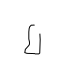

label: 0 ear
[[  8.73426    -3.4456143  -2.8937361   3.5100548 -14.610301  -13.983657  -14.497952  -13.956998  -14.445355  -14.28438   -13.988605  -14.41718   -14.834941  -14.494463  -14.68476   -14.518985 ]]


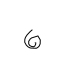

label: 0 ear
[[  4.3350463  -0.9633353  -1.0468148   3.856039  -17.428745  -16.966135  -16.510649  -16.885283  -17.426928  -17.506153  -17.357618  -17.293158  -17.03503   -17.271488  -16.963871  -16.784222 ]]


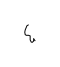

label: 0 ear
[[  7.7858577  -6.0240273  -1.972366    5.006113  -11.774026  -11.583756  -11.18999   -11.961661  -11.54235   -11.52779   -11.396412  -11.895141  -11.812611  -11.597813  -11.758876  -11.631127 ]]


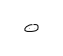

label: 2 mouth
[[ -0.951257    0.6196834   3.2868574   2.5892951 -15.396306  -15.167618  -14.865975  -15.106823  -15.499132  -15.220073  -15.194564  -15.571578  -15.13368   -14.818616  -15.089442  -15.192123 ]]


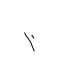

label: 0 ear
[[  4.6562295  -3.4980392  -1.6804157   4.6047854 -10.2153015 -10.3824625 -10.517129  -10.650349  -10.522127  -10.347377  -10.095009  -10.799865  -10.523768  -10.363991  -10.446025  -10.091741 ]]


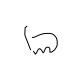

label: 0 ear
[[  4.509206    -3.8478332   -0.21547344   4.391723   -17.92712    -18.056791   -17.586746   -18.19865    -17.903896   -17.252253   -17.746677   -18.005535   -17.582968   -17.48057    -18.163492
  -17.613106  ]]


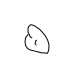

label: 0 ear
[[  4.174126    -0.59489775  -1.1232761    2.385687   -17.383818   -16.833963   -16.23199    -16.41453    -16.606087   -16.824268   -16.76135    -16.601616   -16.550291   -16.7199     -16.372284
  -16.70125   ]]


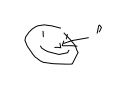

label: 2 mouth
[[ -1.199878   -1.3362639   3.843032    2.34319   -15.970884  -16.468204  -15.812632  -16.202507  -16.312695  -16.277134  -16.3086    -16.204159  -16.366753  -16.236238  -15.695571  -16.11453  ]]


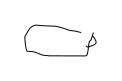

label: 1 eye
[[  0.8751073   3.2144241   2.5142324  -1.5960442 -14.571151  -14.448351  -14.7551775 -14.250086  -14.940049  -13.691052  -14.560079  -14.779403  -14.469599  -14.4399    -14.804231  -14.891187 ]]


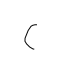

label: 0 ear
[[  7.7578216  -6.2975664  -3.4005098   6.8074775 -12.670738  -12.690861  -12.542117  -12.545557  -12.509249  -12.550757  -12.816788  -12.72587   -12.965147  -12.563142  -12.663656  -12.202178 ]]


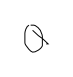

label: 0 ear
[[  5.456684   -0.5462448  -1.2191362   1.9569321 -17.239817  -16.594042  -16.194118  -16.240734  -16.727747  -16.945763  -16.78737   -16.765274  -16.770542  -16.730425  -16.36731   -16.342306 ]]


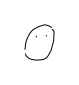

label: 0 ear
[[  3.8601627   0.3169036  -1.2772155   3.842076  -16.896173  -16.315498  -16.772377  -16.083918  -16.946695  -16.601055  -16.545544  -16.718288  -17.126415  -16.621738  -16.98789   -16.937834 ]]


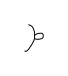

label: 0 ear
[[  8.538778   -4.345326   -2.2466333   3.2204835 -17.65964   -17.505941  -17.497246  -17.473131  -18.017763  -17.535803  -17.603283  -17.694681  -17.884293  -17.845541  -18.188646  -17.777958 ]]


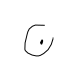

label: 0 ear
[[  3.2366226    0.35175133  -1.4083073    2.9185379  -14.05961    -13.940182   -13.156894   -13.620086   -14.124628   -13.789401   -13.436128   -13.902397   -13.544887   -13.502504   -13.603611
  -13.570386  ]]


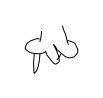

label: 2 mouth
[[ -0.6632327  -0.9212438   2.8686957   2.7287152 -13.314892  -13.216311  -12.723401  -12.698786  -13.022391  -12.786945  -12.45847   -13.655773  -12.344493  -12.699256  -13.02479   -12.884102 ]]


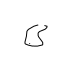

label: 0 ear
[[  3.9291925    0.41645515  -2.0848832    3.8700812  -16.72231    -16.076056   -16.460056   -15.961626   -16.720076   -16.409004   -16.466125   -16.460268   -16.51614    -16.44352    -16.483166
  -16.538225  ]]
[32, 6, 4, 2458, 0]


In [19]:
data = np.load("datasets/nose.npz")
test_data = data['valid']
labels = ['ear','eye','mouth','nose']
counts = [0,0,0,0,0]
scale_factor = 45.8033
for i in range(2500):
    stroke = test_data[i]
    stroke = np.array(stroke, dtype=np.float32)
    stroke[:, 0:2] /= scale_factor
    prediction = predict_model(sess,eval_model,stroke,125)
    counts[prediction] += 1
    label = labels[prediction]
    if not(label == "nose"):
        draw_strokes(stroke)
        print("label: " + str(prediction) + " " + label)
        p = pred(sess, eval_model, stroke, 125)
        print p
print counts

In [45]:
#PRINTS IMAGES WITH HIGHEST AND LOWEST LABELS
data = np.load("datasets/mouth.npz")
test_data = data['valid']
labels = ['ear','eye','mouth','nose']
scale_factor = 45.8033
pred_num = []
for i in range(2500):
    stroke = test_data[i]
    stroke = np.array(stroke, dtype=np.float32)
    stroke[:, 0:2] /= scale_factor
    p = pred(sess, eval_model, stroke, 125)
    p_num = p[0][2]
    pred_num.append(p_num)
sorted_p = np.argsort(pred_num)

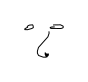

[[ -0.64687324  -5.131003    -1.2524068   11.37496    -18.010033   -17.059332   -17.529608   -17.986235   -17.850002   -18.039457   -18.13101    -17.939508   -17.36545    -17.976534   -18.327503
  -17.477161  ]]


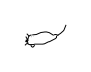

[[-0.49817422  4.554924   -0.7652664  -0.461442   -9.390339   -9.902523   -9.474994   -9.7926855  -9.517262   -9.30693    -9.004649   -9.918789   -9.305601   -9.372185   -9.790344   -9.742571  ]]


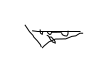

[[ -1.8618633    6.753933    -0.58560115  -1.5992247  -13.2350855  -12.560534   -12.769067   -13.252769   -13.390563   -12.8884115  -13.150419   -13.11845    -13.096975   -13.025946   -12.705798
  -13.306389  ]]


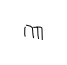

[[  3.7047577  -2.245174   -0.2573092   3.563629  -14.326581  -13.6224375 -14.131119  -14.547011  -14.237199  -13.514454  -13.693232  -13.899979  -13.870303  -13.870881  -14.526929  -13.876386 ]]


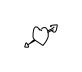

[[  4.534894    -1.1486832   -0.09281635   1.8130434  -13.33804    -13.083276   -12.961343   -12.91254    -13.233613   -12.788306   -12.398864   -13.180435   -13.366968   -12.961818   -13.15155
  -13.096581  ]]


In [48]:
highest = []
lowest = []
for i in range(0,5):
    index = sorted_p[i]
    stroke = test_data[index]
    stroke = np.array(stroke, dtype=np.float32)
    stroke[:, 0:2] /= scale_factor
    lowest.append([stroke,[0,i]])
    draw_strokes(stroke)
    p = pred(sess, eval_model, stroke, 125)
    print p
    #print pprint("HIGHEST")
highest = []
j = 0
for i in range(2495,2500):
    index = sorted_p[i]
    stroke = test_data[index]
    stroke = np.array(stroke, dtype=np.float32)
    stroke[:, 0:2] /= scale_factor
    highest.append([stroke,[0,j]])
    #draw_strokes(stroke)
    p = pred(sess, eval_model, stroke, 125)
    #print p
    j += 1

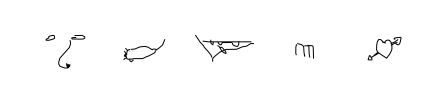

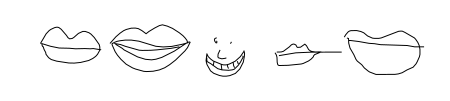

In [49]:
l = make_grid_svg(lowest)
draw_strokes(l)
h = make_grid_svg(highest)
draw_strokes(h)